# Vehichle Detection

This is the first module for the Self Driving Car simulation. This notebook is for visualizing vehicle detection results using the following machine learning and computer vision techniques. 

* Linear SVM: Creates an SVM model in a CPU which scales according to the size of the training data
* Histogram of Oriented Gradients feature extraction: Breaks up image into regions and detecting local objects using light gradients or edge detection
* Color Space Conversion
* Space binning: Grouping data into smaller intervals
* Histogram of color extraction
* Sliding window

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import cv2

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Helper Functions

In [2]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block,
                    vis=False, feature_vec=True):
    """Returns features from an array of Oriented Gradients"""
    if vis == True:
        features, hog_image = hog(image, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(image, orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        transform_sqrt=False,
                        visualize=vis, feature_vector=feature_vec)
        return features  

In [3]:
def color_hist(img, nbins=32):    
    """Compute the histogram of the color channels separately"""
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features       

In [4]:
def spatial_bin(img, size=(32, 32)):
    """Creates an array with rgb values"""
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [8]:
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                    hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extracts features from a list of 32x32 images"""
    
    # create a list to appened feature vectors
    features = []
    for file in images:
        file_features = []
        image = mpimg.imread(file)
        # if it's not an 'RGB' photo, apply color conversion
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.Color_RGB2HSV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.Color_RGB2HLS)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.Color_RGB2LUV)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.Color_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.Color_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        if spatial_feature == True:
            spatial_features = spatial_bin(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # apply histogram computations
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                        orient, pix_per_cell, cell_per_block,
                                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                               pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            # append new feature vector to the list of features
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        return features

## Collect Data

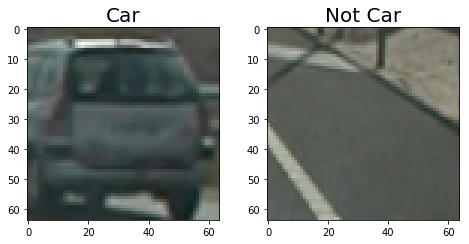

In [20]:
images = glob.glob('./data/OwnCollection/*/*/*.png')
cars = []
notcars = []
all_cars = []
all_notcars = []

# collect images
for image in images:
    if 'non-vehicle' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)

# avoid overfitting by collecting only a fraction of the data
for i, notcar in enumerate(all_notcars):
    if i % 5 == 0:
        notcars.append(notcar)
        
for i, car in enumerate(all_cars):
    if i % 5 == 0:
        cars.append(car)

car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[5])      

def compare_images(first_img, second_img, first_img_exp="Image 1", second_img_exp="Image 2"):
    """Draws a side by side comparison of the dataset pictures"""
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(first_img)
    ax1.set_title(first_img_exp, fontsize=20)
    ax2.imshow(second_img)
    ax2.set_title(second_img_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

compare_images(car_image, notcar_image, "Car", "Not Car")